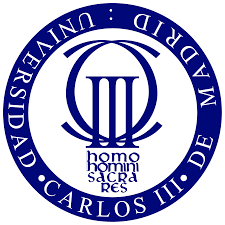

# PRÁCTICA 1: Procesamiento de datos mediante Apache Spark

Autores: Pablo Hidalgo Delgado, Till Niklas Kobele, Juan Romero Sanz, Juan María Villard Bardón.

NIAs: 100451225, 100548395, 100535977, 100439614.

Grupo de prácticas: D


## Índice
- [1. Introducción](#1.-Introducción)

- [2. Lectura de los datos](#2.-Lectura-de-los-datos)

    - [2.1 Trip data](#2.1-Trip-data)
 
    - [2.2 Zone data](#2.2-Zone-data)

- [3. Análisis exploratorio de los datos](#2.-Análisis-exploratorio-de-los-datos)
      
    - [3.1 Trip data](#3.1-Trip-data)
 
    - [3.2 Zone data](#3.2-Zone-data)


- [4. Preproceso de los datos](#4.-Preproceso-de-los-datos)

    - [4.1 Conversión de formato de fecha al formato UNIX (timestamp)](#4.1-Conversión-de-formato-de-fecha-al-formato-UNIX-(timestamp))


.

.

.


  
- [Conclusión](#conclusión)

## 1. Introducción

Este proyecto consiste en un análisis de los datos de viajes de taxis de YellowCab en la ciudad de Nueva York, utilizando Apache Spark para procesar grandes volúmenes de datos. Se realizan estudios sobre:

- Velocidad media de los taxis en función de la hora.
  
- Viajes en taxi más comunes.

- Registros financieros (propinas, recuento de pasajeros, etc.).
  
Esto se consigue mediante la implementación de consultas mediante Spark SQL, DataFrames y RDDs. El objetivo principal es realizar un análisis de rendimiento comparativo entre estas técnicas.


`revisar introducción`

## 2. Lectura de los datos

### 2.1 Trip data

En primer lugar, leemos el conjunto de datos principal, que se encontrará almacenado en el archivo data/tripdata_2017-01.csv. Este fichero contiene datos estructurados sobre los viajes en taxi en la ciudad de Nueva York durante el mes de Enero de 2017.

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


spark = SparkSession.builder.master('local[3]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

In [2]:
# Definimos la ruta del archivo CSV
route_trip_data = "data/tripdata_2017-01.csv"

# Leemos el archivo CSV como un DataFrame de Spark
trip_data_df = spark.read.csv(route_trip_data, header=True, inferSchema=True)

print(type(trip_data_df))

<class 'pyspark.sql.dataframe.DataFrame'>


Se obtiene un objeto dataframe de Spark con los datos almacenados.

### 2.2 Zone data

De la misma manera, leemos el archivo csv que contiene información sobre las distintas zonas de la ciudad de Nueva York. Este archivo se incluye en la práctica con el objetivo de ampliar nuestro dataset principal, añadiendo información sobre las zonas en que se tomaron los taxis.

In [3]:
# Leemos el fichero con información sobre las zonas
route_zone_data = "data/taxi_zone_lookup.csv"

# Leemos el archivo CSV como un DataFrame de Spark
zone_data_df = spark.read.csv(route_zone_data, header=True, inferSchema=True)

## 3. Análisis exploratorio de los datos

Antes de empezar con las operaciones y el análisis, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestros datasets. Esto nos servirá para comprender mejor los conjuntos de datos.

### 3.1 Trip data

In [4]:
trip_data_df.toPandas()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.00,0.3,15.30
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.00,0.3,7.25
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.00,0.3,7.30
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.00,0.3,8.50
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971005,2,2017-01-17 13:16:22,2017-01-17 13:35:14,1,3.43,1,N,264,264,2,14.5,0.0,0.5,0.00,0.00,0.3,15.30
971006,2,2017-01-17 13:16:23,2017-01-17 13:23:01,1,0.78,1,N,161,237,1,6.0,0.0,0.5,1.36,0.00,0.3,8.16
971007,2,2017-01-17 13:16:23,2017-01-17 13:23:51,1,0.95,1,N,237,229,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30
971008,2,2017-01-17 13:16:23,2017-01-17 13:32:45,1,1.68,1,N,170,48,1,11.5,0.0,0.5,2.46,0.00,0.3,14.76


In [5]:
trip_data_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)



El conjunto de datos se compone de **971010 filas y 17 atributos**. En cuanto a las columnas, 8 contienen valores de tipo double, 6 contienen valores enteros (integer), 2 contienen valores de tipo timestamp (fecha) y 1 contiene valores de tipo string. Inspeccionando la página web [NYC TLC Trip Record Data](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page), podemos encontrar el significado de todos estos atributos.

In [6]:
trip_data_df.describe().toPandas()

,summary,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,count,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010,971010
1,mean,1.5569510097733288,1.6859888157691476,3.0312848786315643,1.0447286845655555,None,160.37803112223355,158.5567120832947,1.3719735121162502,13.108188154601873,0.20999277041431086,0.4972142408420099,1.6790282695338843,0.28018088382194434,0.29962863410438667,16.078110822698864
2,stddev,0.4967462497187955,1.2917046837574053,3.785847233211693,0.461631265374306,None,67.93819834229247,72.27682104933919,0.5033263270235144,546.7369331190969,0.26163400368201367,0.04058594644609136,2.5713641104199754,1.7369077136569446,0.01446841089918546,546.7901022658588
3,min,1,0,0.0,1,N,1,1,1,-120.0,-1.0,-0.5,-6.06,0.0,-0.3,-120.3
4,max,2,9,151.7,99,Y,265,265,4,538579.2,55.54,0.5,366.0,905.54,0.3,538580.0


### 3.2 Zone data

In [7]:
zone_data_df.toPandas()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,N/A,N/A


In [8]:
zone_data_df.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



El conjunto de datos se compone de **265 filas y 4 atributos**. Cada fila se corresponde con una zona distinta de Nueva York, identificada por la columna `LocationID`

In [9]:
zone_data_df.describe().toPandas()

,summary,LocationID,Borough,Zone,service_zone
0,count,265,265,265,265
1,mean,133.0,None,None,None
2,stddev,76.643112323722,None,None,None
3,min,1,Bronx,Allerton/Pelham Gardens,Airports
4,max,265,Unknown,Yorkville West,Yellow Zone


## 4. Preproceso de los datos

Antes de empezar con las distintas operaciones, realizamos un pequeño preproceso de los datos para tenerlos en el formato más adecuado y objetivo para la realización de la práctica.

### 4.1 Conversión de formato de fecha al formato UNIX (timestamp)

En el apartado anterior, observamos que las columnas **tpep_pickup_datetime** y **tpep_dropoff_datetime** contienen fechas (como era de esperar) en formato cadena (string) con el formato aaaa-mm-dd hh:mm:ss. 

Para poder trabajar y realizar operaciones matemáticas con estos valores de fechas, es necesario convertirlas a un formato que permita cálculos y comparaciones eficientes, como el formato UNIX (timestamp), el cual representa el número de segundos transcurridos desde el 1 de enero de 1970.

In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

datetime_to_UNIX = lambda dt: int(dt.timestamp())
datetime_to_UNIX_udf = udf(datetime_to_UNIX, IntegerType())

trip_data_df_unix = (
    trip_data_df
    .withColumn("tpep_pickup_datetime_unix", datetime_to_UNIX_udf(trip_data_df['tpep_pickup_datetime']))
    .withColumn("tpep_dropoff_datetime_unix", datetime_to_UNIX_udf(trip_data_df['tpep_dropoff_datetime']))
)

trip_data_df_unix.printSchema()
trip_data_df_unix.limit(5).toPandas()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tpep_pickup_datetime_unix: integer (nullable = true)
 |-- tpep_dropoff_datetime_unix: integer (nullable = true)



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_datetime_unix,tpep_dropoff_datetime_unix
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,12.5,0.0,0.5,2.00,0.0,0.3,15.30,1483960408,1483961145
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,5.0,0.0,0.5,1.45,0.0,0.3,7.25,1483961547,1483961761
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,5.5,0.0,0.5,1.00,0.0,0.3,7.30,1483961900,1483962125
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,6.0,0.0,0.5,1.70,0.0,0.3,8.50,1483962733,1483963056
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,52.0,0.0,0.5,0.00,0.0,0.3,52.80,1483228800,1483228800


### 4.2 Unión de las 2 fuentes de datos

Para ampliar nuestro conjunto de datos y agregar información adicional, vamos a incorporar detalles sobre las zonas de Nueva York en las que inició y finalizó cada viaje de taxi. Para ello, realizamos dos uniones (joins) entre nuestro conjunto de datos de viajes y el conjunto de datos de zonas, utilizando el atributo LocationID del dataset de zonas y los atributos PULocationID (zona de inicio del viaje o donde se activó el taxímetro) y DOLocationID (zona de finalización del viaje o donde se apagó el taxímetro) del dataset de viajes.

In [5]:
from pyspark.sql import functions as F

# Hacemos el join por la el ID de Localización en que se inició el trayecto y seleccionamos las columnas con los nombres necesarios
trip_data_df_unix_joined = (
    trip_data_df_unix.alias("trip_data")
    .join(zone_data_df.alias("pickup_zone"), F.col("trip_data.PULocationID") == F.col("pickup_zone.LocationID"), "inner")
    .join(zone_data_df.alias("dropoff_zone"), F.col("trip_data.DOLocationID") == F.col("dropoff_zone.LocationID"), "inner")
    .select(
        "trip_data.*",  # Todas las columnas originales de trip_data
        F.col("pickup_zone.service_zone").alias("Pickup_service_zone"),  # Seleccionamos y renombramos las columnas de pickup_zone
        F.col("pickup_zone.Borough").alias("Pickup_Borough"),
        F.col("pickup_zone.Zone").alias("Pickup_Zone"),
        F.col("dropoff_zone.service_zone").alias("Dropoff_service_zone"),  # Seleccionamos y renombramos las columnas de dropff_zone
        F.col("dropoff_zone.Borough").alias("Dropoff_Borough"),
        F.col("dropoff_zone.Zone").alias("Dropoff_Zone")
    )
)

trip_data_df_unix_joined.printSchema()

trip_data_df_unix_joined.limit(5).toPandas()


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- tpep_pickup_datetime_unix: integer (nullable = true)
 |-- tpep_dropoff_datetime_unix: integer (nullable = true)
 |-- Pickup_service_zone: string (nullable = true)
 |-- Pickup_Borough: string (nullable = true)
 |-- P

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,tpep_pickup_datetime_unix,tpep_dropoff_datetime_unix,Pickup_service_zone,Pickup_Borough,Pickup_Zone,Dropoff_service_zone,Dropoff_Borough,Dropoff_Zone
0,1,2017-01-09 11:13:28,2017-01-09 11:25:45,1,3.30,1,N,263,161,1,...,0.3,15.30,1483960408,1483961145,Yellow Zone,Manhattan,Yorkville West,Yellow Zone,Manhattan,Midtown Center
1,1,2017-01-09 11:32:27,2017-01-09 11:36:01,1,0.90,1,N,186,234,1,...,0.3,7.25,1483961547,1483961761,Yellow Zone,Manhattan,Penn Station/Madison Sq West,Yellow Zone,Manhattan,Union Sq
2,1,2017-01-09 11:38:20,2017-01-09 11:42:05,1,1.10,1,N,164,161,1,...,0.3,7.30,1483961900,1483962125,Yellow Zone,Manhattan,Midtown South,Yellow Zone,Manhattan,Midtown Center
3,1,2017-01-09 11:52:13,2017-01-09 11:57:36,1,1.10,1,N,236,75,1,...,0.3,8.50,1483962733,1483963056,Yellow Zone,Manhattan,Upper East Side North,Boro Zone,Manhattan,East Harlem South
4,2,2017-01-01 00:00:00,2017-01-01 00:00:00,1,0.02,2,N,249,234,2,...,0.3,52.80,1483228800,1483228800,Yellow Zone,Manhattan,West Village,Yellow Zone,Manhattan,Union Sq


## 5. Medición del rendimiento en base a distintas formas de consultas con Spark

Una vez finalizado el análisis exploratorio y el preprocesamiento del conjunto de datos, y habiendo preparado los datos en el formato adecuado para su análisis, pasamos a abordar el objetivo principal de esta práctica: implementar consultas en Spark utilizando tres enfoques diferentes (SparkSQL, DataFrames de Spark y RDDs) y analizar el rendimiento de cada método.

Para lograr esto, partiremos del DataFrame `trip_data_df_unix_joined`, que contiene las fechas en formato UNIX y la información completa sobre las zonas de inicio y finalización de cada trayecto. La comparativa de rendimiento entre estos métodos nos permitirá entender las ventajas y limitaciones de cada enfoque en Spark y decidir cuál se adapta mejor según los distintos casos de uso en procesamiento de datos a gran escala.

### 5.1 Velocidad media de los taxis en función de la hora

A continuación, vamos a analizar el rendimiento de la obtención de la velocidad media de los taxis en función de la hora. 
La lógica general que seguimos para este proceso es la siguiente:

1. **Calcular la duración del viaje en horas**: Usaremos los timestamps de recogida y entrega (tpep_pickup_datetime y tpep_dropoff_datetime) para calcular la duración en horas.
   
2. **Calcular la velocidad media**: La velocidad media se obtiene dividiendo la distancia del viaje (trip_distance) entre la duración del viaje en horas.

3. **Extraer la hora de recogida**: Para analizar la velocidad media por hora del día, extraemos la hora de la columna tpep_pickup_datetime.

4. **Agrupar por la hora y calcular la media**.

Para realizar el cálculo de velocidad media, es necesario dividir la distancia recorrida por la duración del viaje. Sin embargo, debemos tener especial cuidado con los casos en los que la duración del viaje sea igual a 0, ya que esto resultaría en una división entre cero.

Es importante destacar que, mientras que tanto los DataFrames como SparkSQL manejan las divisiones por cero sin generar errores (en tales casos, el resultado se devuelve como un valor nulo, que se ignora al calcular promedios), los RDDs (Resilient Distributed Datasets) sí que arrojan errores en estas operaciones. Por lo tanto, antes de proceder con los cálculos, es fundamental verificar si existen viajes con una duración de 0 en nuestro conjunto de datos.

In [35]:
# Filtrar el DataFrame donde la duración es 0
zero_duration_df = trip_data_df_unix_joined.filter(
    (trip_data_df_unix_joined["tpep_dropoff_datetime_unix"] - trip_data_df_unix_joined["tpep_pickup_datetime_unix"]) == 0
)

# Contar cuántas filas tienen duración 0
zero_duration_count = zero_duration_df.count()

# Mostrar el resultado
print(f"Número de viajes con duración 0: {zero_duration_count}")

Número de viajes con duración 0: 889


Observamos que existen viajes con una duración de 0. Por lo tanto, con el objetivo de que todas las consultas realicen pasos similares y así ser más exactos en la comparación del rendimiento entre los diferentes enfoques, procederemos a filtrar las filas donde la duración del viaje sea mayor que 0.

#### 5.1.1 Dataframes de Spark

In [34]:
import time 

# 1. Calculamos la duración del viaje en horas
trip_data_df_unix_joined_df = trip_data_df_unix_joined.withColumn(
    "trip_duration_hours",
    (F.col("tpep_dropoff_datetime_unix") - F.col("tpep_pickup_datetime_unix")) / 3600
)

# 2. Filtramos las filas donde la duración del viaje es mayor que 0
trip_data_df_unix_joined_df = trip_data_df_unix_joined_df.filter(F.col("trip_duration_hours") > 0)

# 3. Calculamos la velocidad media en función de la duración y distancia del viaje
trip_data_df_unix_joined_df = trip_data_df_unix_joined_df.withColumn(
    "avg_speed",
    F.col("trip_distance") / F.col("trip_duration_hours")
)

# 4. Extraemos la hora de la columna tpep_pickup_datetime para hacer el análisis por hora del día
trip_data_df_unix_joined_df = trip_data_df_unix_joined_df.withColumn(
    "pickup_hour",
    F.hour("tpep_pickup_datetime")
)

# 5. Agrupamos por la hora del día y calcular la velocidad media
avg_speed_by_hour = trip_data_df_unix_joined_df.groupBy("pickup_hour").agg(
    F.avg("avg_speed").alias("average_speed")
).orderBy("pickup_hour")

initial_time_avg_speed_df = time.time()
avg_speed_by_hour_df = avg_speed_by_hour.toPandas()
final_time_avg_speed_df = time.time()

elapsed_time_avg_speed_df = final_time_avg_speed_df - initial_time_avg_speed_df

print("TIEMPO QUE HA TARDADO EN REALIZARSE LA CONSULTA (SPARK DATAFRAMES): ", elapsed_time_avg_speed_df, "segundos\n")
print(avg_speed_by_hour_df)

TIEMPO QUE HA TARDADO EN REALIZARSE LA CONSULTA:  9.050175666809082 segundos

    pickup_hour  average_speed
0             0      15.772703
1             1      14.893825
2             2      15.756148
3             3      17.525558
4             4      20.431103
5             5      22.738700
6             6      19.460598
7             7      14.693576
8             8      14.160717
9             9      13.465958
10           10      14.408612
11           11      13.260485
12           12      13.200561
13           13      12.856998
14           14      14.236443
15           15      12.733851
16           16      16.185656
17           17      13.222233
18           18      13.143431
19           19      15.388003
20           20      14.675626
21           21      15.237884
22           22      17.185439
23           23      19.342114


#### 5.1.2 SparkSQL

In [26]:
# 1. Registramos el DataFrame original como una vista temporal para poder usar SQL
trip_data_df_unix_joined.createOrReplaceTempView("trip_data")

# 2. Ejecutamos la consulta unificada en SQL
avg_speed_by_hour_sql_query = """
    SELECT 
        hour(tpep_pickup_datetime) AS pickup_hour,
        AVG(trip_distance / ((tpep_dropoff_datetime_unix - tpep_pickup_datetime_unix) / 3600)) AS average_speed
    FROM 
        trip_data
    WHERE 
        (tpep_dropoff_datetime_unix - tpep_pickup_datetime_unix) > 0  -- Para evitar divisiones por cero
    GROUP BY 
        hour(tpep_pickup_datetime)
    ORDER BY 
        pickup_hour
"""

# Medimos el tiempo de ejecución de la consulta
initial_time_avg_speed_sql = time.time()
avg_speed_by_hour_sql = spark.sql(avg_speed_by_hour_sql_query).toPandas()
final_time_avg_speed_sql = time.time()

elapsed_time_avg_speed_sql = final_time_avg_speed_sql - initial_time_avg_speed_sql

# Imprimimos el tiempo de ejecución y el resultado en formato tabla
print("TIEMPO QUE HA TARDADO EN REALIZARSE LA CONSULTA (SPARKSQL): ", elapsed_time_avg_speed_sql, "segundos\n")
print(avg_speed_by_hour_sql)


TIEMPO QUE HA TARDADO EN REALIZARSE LA CONSULTA:  10.110698699951172 segundos

    pickup_hour  average_speed
0             0      15.772703
1             1      14.893825
2             2      15.756148
3             3      17.525558
4             4      20.431103
5             5      22.738700
6             6      19.460598
7             7      14.693576
8             8      14.160717
9             9      13.465958
10           10      14.408612
11           11      13.260485
12           12      13.200561
13           13      12.856998
14           14      14.236443
15           15      12.733851
16           16      16.185656
17           17      13.222233
18           18      13.143431
19           19      15.388003
20           20      14.675626
21           21      15.237884
22           22      17.185439
23           23      19.342114


#### 5.1.3 RDDs

In [38]:
import time
from pyspark.sql import Row

# Convertimos el DataFrame a RDD
trip_data_rdd = trip_data_df_unix_joined.rdd

# Definimos una función para calcular la velocidad media y extraer la hora de recogida
def calculate_speed(row):
    # Calculamos la duración del viaje en horas
    trip_duration_hours = (row['tpep_dropoff_datetime_unix'] - row['tpep_pickup_datetime_unix']) / 3600
    # Extraemos la hora de la columna de fecha y hora de recogida
    pickup_hour = row['tpep_pickup_datetime'].hour
    return (pickup_hour, trip_duration_hours, row['trip_distance'])

# Medimos el tiempo de ejecución
initial_time_avg_speed_rdd = time.time()

# Filtramos las filas donde la duración del viaje es mayor que 0 y luego calculamos la velocidad media
avg_speed_by_hour_rdd = (
    trip_data_rdd
    .map(calculate_speed)                          # Calculamos la duración del viaje y recogemos la información necesaria
    .filter(lambda x: x[1] > 0)                    # Filtramos filas donde la duración es mayor que 0
    .map(lambda x: (x[0], x[2] / (x[1])))          # Calculamos la velocidad media
    .groupByKey()                                   # Agrupamos por hora
    .mapValues(lambda speeds: sum(speeds) / len(speeds))  # Calculamos el promedio
    .sortByKey()                                    # Ordenamos por la hora
)

# Convertimos a DataFrame de pandas
avg_speed_by_hour_rdd_df = avg_speed_by_hour_rdd.toDF(["pickup_hour", "average_speed"]).toPandas()

# Medimos el tiempo final
final_time_avg_speed_rdd = time.time()
elapsed_time_avg_speed_rdd = final_time_avg_speed_rdd - initial_time_avg_speed_rdd

# Imprimimos el tiempo de ejecución y el resultado
print("TIEMPO QUE HA TARDADO EN REALIZARSE LA CONSULTA (RDD): ", elapsed_time_avg_speed_rdd, "segundos\n")
print(avg_speed_by_hour_rdd_df)


TIEMPO QUE HA TARDADO EN REALIZARSE LA CONSULTA (RDD):  19.273934364318848 segundos

    pickup_hour  average_speed
0             0      15.772703
1             1      14.893825
2             2      15.756148
3             3      17.525558
4             4      20.431103
5             5      22.738700
6             6      19.460598
7             7      14.693576
8             8      14.160717
9             9      13.465958
10           10      14.408612
11           11      13.260485
12           12      13.200561
13           13      12.856998
14           14      14.236443
15           15      12.733851
16           16      16.185656
17           17      13.222233
18           18      13.143431
19           19      15.388003
20           20      14.675626
21           21      15.237884
22           22      17.185439
23           23      19.342114
